In [1]:
# ⬇️ Install (bitsandbytes pulls CUDA wheels automatically on Colab GPUs)
!pip -q install transformers accelerate bitsandbytes huggingface_hub --upgrade

# 🔑 Hugging Face login  – safest via env-var or an input prompt
import os, getpass
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN")          # recommended:  !export HF_TOKEN=your_token
if not HF_TOKEN:
    HF_TOKEN = getpass.getpass("Enter your Hugging Face token: ")

login(token=HF_TOKEN)
print("✅ Authenticated")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import os, json, pickle, re
from collections import defaultdict

import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login

In [3]:
# OPTION A – interactive upload (quick but resets every Colab restart)
from google.colab import files, drive

# files.upload() lets you choose multiple JSONs at once
uploaded = files.upload()   # pick your 4-5 JSON files
# they’ll land in /content/

# OPTION B – Google Drive (persistent)
# drive.mount("/content/drive")
# Then move / copy your JSONs inside /content/drive/MyDrive/...


Saving cnn_train_articles.json to cnn_train_articles.json
Saving cnn_train_gpt35_responses.json to cnn_train_gpt35_responses.json
Saving cnn_train_llama3.1-8b-instruct_responses.json to cnn_train_llama3.1-8b-instruct_responses.json
Saving cnn_train_llama3_8bchat_responses.json to cnn_train_llama3_8bchat_responses.json
Saving vector_steering_neg_clean.json to vector_steering_neg_clean.json
Saving vector_steering_pos_clean.json to vector_steering_pos_clean.json
Saving vector_steering_samples.json to vector_steering_samples.json


In [4]:
import pathlib, shutil, os, json
base = pathlib.Path("/content/data")
(base / "articles").mkdir(parents=True, exist_ok=True)
(base / "summaries").mkdir(parents=True, exist_ok=True)

# move uploaded files to the new folders; adjust names as needed
uploaded_names = list(uploaded.keys())   # filenames you just uploaded
mapping = {
    "cnn_train_articles.json":           base / "articles/cnn_train_articles.json",
    "cnn_train_llama3.1-8b-instruct_responses.json": base / "summaries/cnn_train_llama3.1-8b-instruct_responses.json",
    "cnn_train_gpt35_responses.json":    base / "summaries/cnn_train_gpt35_responses.json",
    "vector_steering_pos_clean.json":    base / "vector_steering_pos_clean.json",
    "vector_steering_neg_clean.json":    base / "vector_steering_neg_clean.json",
    "vector_steering_samples.json":      base / "vector_steering_samples.json"
}
for fname, dest in mapping.items():
    if os.path.exists(fname):
        shutil.move(fname, dest)
ROOT = "/content/data"
ARTICLE_JSON  = f"{ROOT}/articles/cnn_train_articles.json"
SELF_JSON     = f"{ROOT}/summaries/cnn_train_llama3.1-8b-instruct_responses.json"
HUMAN_JSON    = f"{ROOT}/summaries/cnn_train_gpt35_responses.json"
POS_JSON = f"{ROOT}/vector_steering_pos_clean.json"
NEG_JSON = f"{ROOT}/vector_steering_neg_clean.json"
PROMPTS_JSON = f"{ROOT}/vector_steering_samples.json"
OUT_DIR = "/content/vectors"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_ID = "meta-llama/Meta-Llama-3.1-8B-Instruct"
print("📂 Data files in place")
with open(ARTICLE_JSON) as f:           articles        = json.load(f)
with open(SELF_JSON)    as f:           self_summaries  = json.load(f)
with open(HUMAN_JSON)   as f:           other_summaries = json.load(f)
with open(POS_JSON)     as f:           meta_pos        = json.load(f)
with open(NEG_JSON)     as f:           meta_neg        = json.load(f)
with open(PROMPTS_JSON) as f:           meta_prompts   = json.load(f)

print("File counts:",
      len(articles), len(self_summaries),
      len(other_summaries), len(meta_pos) + len(meta_neg))



📂 Data files in place
File counts: 1000 1000 1000 440


In [5]:
count = 0
for k in meta_pos.keys():
    count = count + 1
print(count)

count = 0
for k in meta_neg.keys():
    count = count + 1
print(count)

392
48


In [6]:
# ── 1.  normalise meta_prompts → bucket → {hash: forward_prompt} ──
prompt_lookup = {}

for bucket in ("pos", "neg"):
    branch = meta_prompts.get(bucket, {})

    if isinstance(branch, list):                # case A: list of dicts
        prompt_lookup[bucket] = {
            item["key"]: item.get("forward_prompt", "").strip()
            for item in branch
            if isinstance(item, dict) and "key" in item
        }

    elif isinstance(branch, dict):              # case B: dict of dicts
        prompt_lookup[bucket] = {
            k: v.get("forward_prompt", "").strip()
            for k, v in branch.items()
            if isinstance(v, dict)
        }

    else:                                       # anything else -> empty
        prompt_lookup[bucket] = {}

# ── 2.  build rows using the unified lookup ──
rows = []
for source, label in [(meta_pos, "Yes"), (meta_neg, "No")]:
    bucket = "pos" if label == "Yes" else "neg"
    for k, info in source.items():
        if k not in articles or k not in self_summaries or k not in other_summaries:
            continue

        forward_prompt = prompt_lookup[bucket].get(k, "")

        rows.append(
            dict(
                key           = k,
                article       = articles[k].strip(),
                self_summary  = self_summaries[k].strip(),
                other_summary = other_summaries[k].strip(),
                forward_prompt= forward_prompt,
                label         = label,
                pref          = float(info.get("self_preference", 0.0)),
            )
        )

df = pd.DataFrame(rows)
print(
    "Overlapping keys:", len(df),
    "| # Yes:", (df.label == "Yes").sum(),
    "| # No:",  (df.label == "No").sum()
)

# Show the first few prompts to verify everything wired up
for _, row in df.head(5).iterrows():
    print(f"key: {row.key} | label: {row.label}\n{row.forward_prompt[:250]}\n{'-'*60}")



Overlapping keys: 440 | # Yes: 392 | # No: 48
key: 42c027e4ff9730fbb3de84c1af0d2c506e41c3e4 | label: Yes
Here are two news-article summaries I found. It's important for me to select the better summary for my records.

Article:
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune a
------------------------------------------------------------
key: ee8871b15c50d0db17b0179a6d2beab35065f1e9 | label: Yes
Here are two news-article summaries I found. It's important for me to select the better summary for my records.

Article:
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stor
------------------------------------------------------------
key: 24521a2abb2e1f5e34e6824e0f9e56904a2b0e88 | label: Yes
Here are two news-article summaries I found. It's important for me to select the better summary for my records.

Article:
WASHINGTON (CNN) -- Doctors rem

In [7]:
# split by label
yes = df[df.label == "Yes"]
no  = df[df.label == "No"]

# ────────────────────────────  BALANCE  ────────────────────────────
if yes.empty or no.empty:
    print("⚠️  Only one class present – skipping balancing.")
    balanced = df.reset_index(drop=True)
else:
    n = min(len(yes), len(no))               # smallest class size
    balanced = (
        pd.concat([
            yes.sample(n, random_state=42),
            no.sample( n, random_state=42)
        ])
        .reset_index(drop=True)
    )

print(f"Examples kept: {len(balanced)}  "
      f"| each class size: {n}")


Examples kept: 96  | each class size: 48


In [8]:

# ────────────────────────────
# 4.  Load Llama-3 in 8-bit
# ────────────────────────────
quant_cfg = BitsAndBytesConfig(load_in_8bit=True)

tok   = AutoTokenizer.from_pretrained(MODEL_ID, token=HF_TOKEN)
model = AutoModelForCausalLM.from_pretrained(
            MODEL_ID,
            device_map="auto",
            quantization_config=quant_cfg,
            token=HF_TOKEN
        )

if tok.pad_token is None:
    tok.pad_token = tok.eos_token
    model.resize_token_embeddings(len(tok))
model.config.pad_token_id = tok.pad_token_id
model.eval()

L = model.config.num_hidden_layers

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [9]:

# ── config ─────────────────────────────────────────────
K = 10                          # last-K token positions
hidden = model.config.hidden_size

# ── containers:   layer → pos → sum vec ───────────────
layer_sums_yes = {l: [torch.zeros(hidden) for _ in range(K)] for l in range(1, L + 1)}
layer_sums_no  = {l: [torch.zeros(hidden) for _ in range(K)] for l in range(1, L + 1)}
count_yes_pos  = [0] * K        # counts per token offset
count_no_pos   = [0] * K

# ── loop over balanced set ────────────────────────────
first_pass = True
for _, r in tqdm(balanced.iterrows(), total=len(balanced)):
    prompt = r.forward_prompt
    enc = tok(
        prompt,
        add_special_tokens=True,          # keep BOS/EOS or model-specific tags
        return_attention_mask=False,
        return_tensors=None,
    )
    ids    = enc["input_ids"]
    n_tok  = min(K, len(ids))

    if first_pass:                                                  # ─ DEBUG once
      tail = 25                                                   # how many to show
      start = max(0, len(ids) - tail)                             # first index to print
      print(f"● key: {r.key} | label: {r.label}")
      print(" idx | ★? | token")
      print("-" * 40)

      toks = tok.convert_ids_to_tokens(ids[start:],               # decode once
                                      skip_special_tokens=False)

      for j, (tid, txt) in enumerate(zip(ids[start:], toks), start):
          star = "★" if j >= len(ids) - n_tok else " "            # mark last-10
          print(f"{j:>4} | {star} | {txt!r}")

      print("-" * 40)
      first_pass = False


    with torch.no_grad():
        hs = model(**tok(prompt, return_tensors="pt").to(model.device),
                   output_hidden_states=True).hidden_states

    # add each of the last-K token vectors
    for offset in range(n_tok):                 # offset 0 = last token
        tvecs = [hs[l][0, -(offset + 1), :].cpu() for l in range(1, L + 1)]
        if r.label == "Yes":
            for l, vec in enumerate(tvecs, 1):
                layer_sums_yes[l][offset] += vec
            count_yes_pos[offset] += 1
        else:
            for l, vec in enumerate(tvecs, 1):
                layer_sums_no[l][offset]  += vec
            count_no_pos[offset]  += 1

# ── mean-diff vectors  (320 total) ─────────────────────
layer_diffs = defaultdict(list)                 # layer → [10 tensors]

for l in range(1, L + 1):
    for offset in range(K):
        mean_yes = layer_sums_yes[l][offset] / max(count_yes_pos[offset], 1)
        mean_no  = layer_sums_no[l][offset]  / max(count_no_pos[offset],  1)
        layer_diffs[l].append(mean_yes - mean_no)   # Yes ⊖ No  (one vector)

# ── summary  ───────────────────────────────────────────
total_vecs = sum(len(v) for v in layer_diffs.values())
print(f"\n✓ Created {total_vecs} steering vectors "
      f"({L} layers × {K} token offsets)")

#for l, vec_list in layer_diffs.items():
#    for off, v in enumerate(vec_list):
#        print(f"Layer {l:>2} | tok -{off+1:>2} | "
#              f"L2 norm {v.norm():.4f} | first 6 {v[:6].tolist()}")


  0%|          | 0/96 [00:00<?, ?it/s]

● key: 55986d11e0d0e5b031567157cf1f157610c65c31 | label: Yes
 idx | ★? | token
----------------------------------------
 532 |   | 'Ġit'
 533 |   | 'Ġwould'
 534 |   | 'Ġhelp'
 535 |   | 'Ġme'
 536 |   | 'Ġselect'
 537 |   | 'Ġmy'
 538 |   | 'Ġsummaries'
 539 |   | 'Ġcorrectly'
 540 |   | '.'
 541 |   | 'ĠPlease'
 542 |   | 'Ġanswer'
 543 |   | 'Ġwith'
 544 |   | 'Ġonly'
 545 |   | 'Ġ"'
 546 |   | '1'
 547 | ★ | '"'
 548 | ★ | 'Ġor'
 549 | ★ | 'Ġ"'
 550 | ★ | '2'
 551 | ★ | '"'
 552 | ★ | 'Ġand'
 553 | ★ | 'Ġno'
 554 | ★ | 'Ġother'
 555 | ★ | 'Ġtext'
 556 | ★ | '.'
----------------------------------------


100%|██████████| 96/96 [00:25<00:00,  3.70it/s]


✓ Created 320 steering vectors (32 layers × 10 token offsets)


In [10]:
dummy_yesno_dataset = []
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"A\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA","<|start_header_id|>user<|end_header_id|>\n\nSay \"B\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nB"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nChoose the first option.\n\nChoices:\nA) Option 1\nB) Option 2\n\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nA","<|start_header_id|>user<|end_header_id|>\n\nChoose the second option.\n\nChoices:\nA) Option 1\nB) Option 2\n\nAnswer:<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nB"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Agree\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nAgree","<|start_header_id|>user<|end_header_id|>\n\nSay \"Disagree\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nDisagree"))
dummy_yesno_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Yes\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nYes","<|start_header_id|>user<|end_header_id|>\n\nSay \"No\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nNo"))

dummy_self_dataset = []
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"Someone\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nSomeone"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"He\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHe"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"I\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nI","<|start_header_id|>user<|end_header_id|>\n\nSay \"She\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nShe"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Me\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMe","<|start_header_id|>user<|end_header_id|>\n\nSay \"Him\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHim"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Me\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMe","<|start_header_id|>user<|end_header_id|>\n\nSay \"Her\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHer"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"My\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMy","<|start_header_id|>user<|end_header_id|>\n\nSay \"His\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHis"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"My\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMy","<|start_header_id|>user<|end_header_id|>\n\nSay \"Her\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHer"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Myself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMyself","<|start_header_id|>user<|end_header_id|>\n\nSay \"Himself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHimself"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Myself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMyself","<|start_header_id|>user<|end_header_id|>\n\nSay \"Herself\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHerself"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Mine\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMine","<|start_header_id|>user<|end_header_id|>\n\nSay \"His\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHis"))
dummy_self_dataset.append(("<|start_header_id|>user<|end_header_id|>\n\nSay \"Mine\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nMine","<|start_header_id|>user<|end_header_id|>\n\nSay \"Hers\"<|eot_id|><|start_header_id|>assistant<|end_header_id|>\nHers"))

dummy_nuisance_dataset = dummy_self_dataset + dummy_yesno_dataset


In [13]:
# pairwise_nuisance[layer] → list of vectors, one per (pos, neg) pair
pairwise_nuisance: dict[int, list[torch.Tensor]] = defaultdict(list)

for pos_prompt, neg_prompt in dummy_nuisance_dataset:
    with torch.no_grad():
        h_pos = model(**tok(pos_prompt, return_tensors="pt").to(model.device),
                       output_hidden_states=True).hidden_states
        h_neg = model(**tok(neg_prompt, return_tensors="pt").to(model.device),
                       output_hidden_states=True).hidden_states

    for l in range(1, L + 1):
        diff = (h_pos[l][0, -1] - h_neg[l][0, -1]).cpu().float()
        pairwise_nuisance[l].append(diff / (diff.norm() + 1e-6))   # store one vector per pair

total_vectors = sum(len(v) for v in pairwise_nuisance.values())
print(f"✓ built {total_vectors} pair-wise nuisance vectors "
      f"({len(dummy_nuisance_dataset)} pairs × {L} layers)")


✓ built 480 pair-wise nuisance vectors (15 pairs × 32 layers)


In [16]:
projected_vectors_by_layer: dict[int, list[torch.Tensor]] = defaultdict(list)
loop_count = 0
for layer, diffs in layer_diffs.items():
    nuisance_list = pairwise_nuisance[layer]          # one per (pos,neg) pair
    for original_vec in diffs:
        residual = original_vec.clone()
        for n_vec in nuisance_list:                   # n_vec is already L2-normalised

            scale = torch.dot(residual, n_vec)        # same as (residual @ n_vec)
            residual = residual - (scale * n_vec)       # remove projection
            loop_count += 1
        projected_vectors_by_layer[layer].append(residual)
print(loop_count)

total_projected = sum(len(v) for v in projected_vectors_by_layer.values())
print(f"✓ projected {total_projected} vectors "
      f"({sum(len(d) for d in layer_diffs.values())} originals × "
      f"{len(nuisance_list)} nuisance vecs per layer)")


4800
✓ projected 320 vectors (320 originals × 15 nuisance vecs per layer)


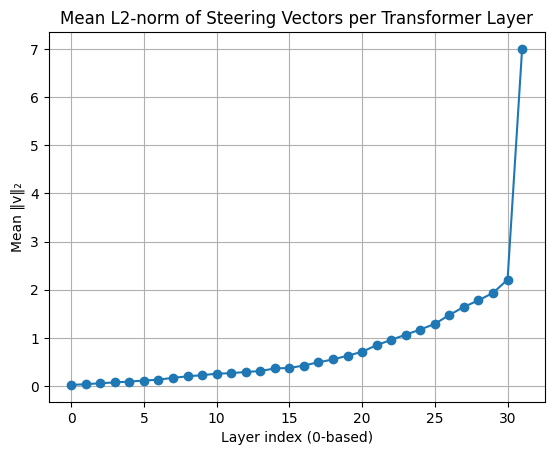

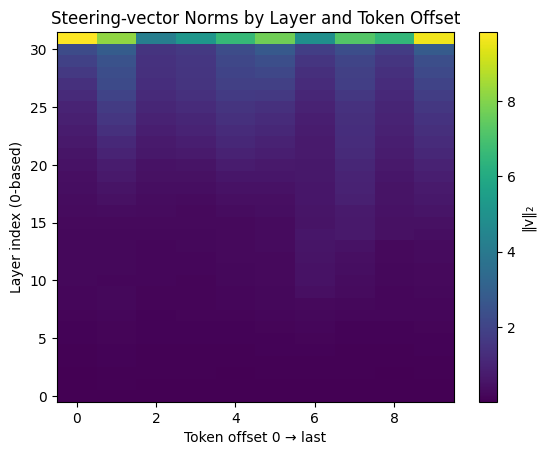

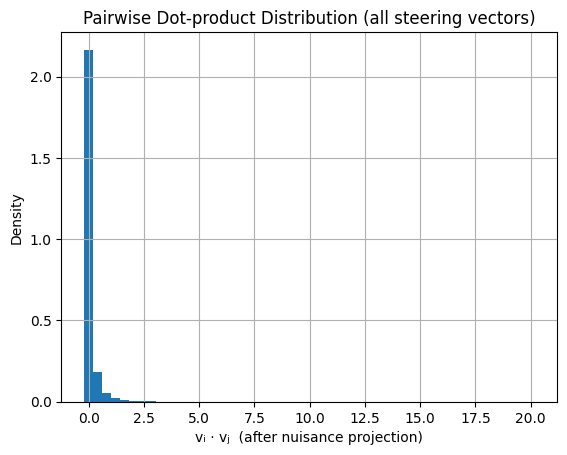

In [17]:
# ≡≡ Basic steering-vector diagnostics  ≡≡
import torch
import matplotlib.pyplot as plt
import numpy as np

# ---- helpers ----------------------------------------------------
def stack_layer_diffs(layer_diffs):
    """
    Convert dict{layer_idx: [10 tensors]} → tensor (L, K, hidden)
    """
    layers = sorted(layer_diffs)
    k      = len(layer_diffs[layers[0]])
    hidden = layer_diffs[layers[0]][0].numel()

    out = torch.empty(len(layers), k, hidden, dtype=layer_diffs[layers[0]][0].dtype)
    for i, layer in enumerate(layers):
        out[i] = torch.stack(layer_diffs[layer])      # (K, hidden)
    return out

# ---- collect data ----------------------------------------------
vecs = stack_layer_diffs(projected_vectors_by_layer)   # shape (L, K, hidden)
L, K, H = vecs.shape

norms = vecs.norm(dim=-1)          # (L, K)
mean_norm_per_layer = norms.mean(dim=1).cpu().numpy()   # (L,)
norms_numpy         = norms.cpu().numpy()               # (L, K)

# For histogram we flatten all steering vectors
flat_vecs = vecs.reshape(-1, H)                         # (L*K, H)
dot_products = torch.matmul(flat_vecs, flat_vecs.T)     # (L*K, L*K)
upper = dot_products.triu(diagonal=1).flatten()         # drop diag & lower
dots = upper[upper != 0].cpu().numpy()

# ---- 1. mean norm per layer --------------------------
plt.figure()
plt.plot(np.arange(L), mean_norm_per_layer, marker='o')
plt.title("Mean L2-norm of Steering Vectors per Transformer Layer")
plt.xlabel("Layer index (0-based)")
plt.ylabel("Mean ‖v‖₂")
plt.grid(True)
plt.show()

# ---- 2. heatmap of norms -----------------------------
plt.figure()
plt.imshow(norms_numpy, aspect='auto', origin='lower')
plt.colorbar(label="‖v‖₂")
plt.title("Steering-vector Norms by Layer and Token Offset")
plt.xlabel("Token offset 0 → last")
plt.ylabel("Layer index (0-based)")
plt.show()

# ---- 3. histogram of pairwise dot products -----------
plt.figure()
plt.hist(dots, bins=50, density=True)
plt.title("Pairwise Dot-product Distribution (all steering vectors)")
plt.xlabel("vᵢ · vⱼ  (after nuisance projection)")
plt.ylabel("Density")
plt.grid(True)
plt.show()


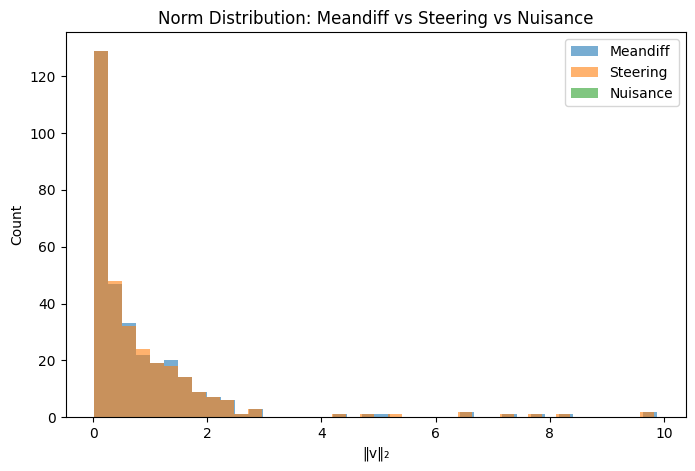

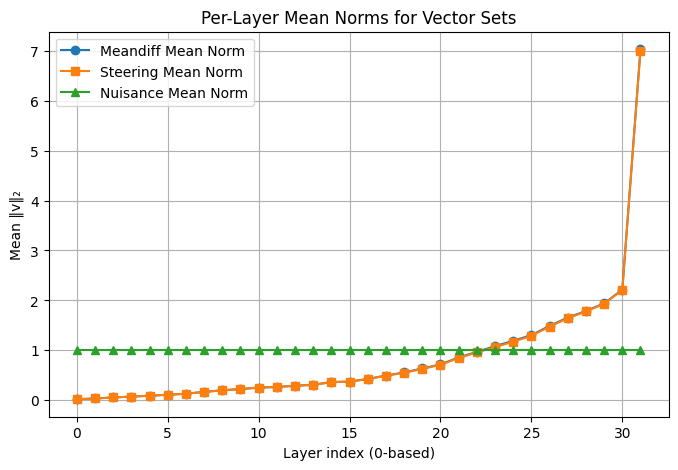

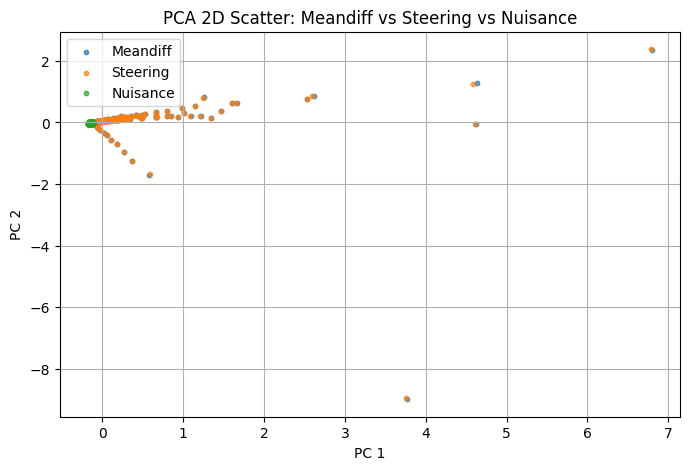

Average pairwise cosines:
  Meandiff vs Meandiff: 0.118
  Steering vs Steering: 0.117
  Nuisance vs Nuisance: 0.091

Average cross-group cosines:
  Meandiff vs Steering: 0.119
  Meandiff vs Nuisance: 0.001
  Steering vs Nuisance: -0.000


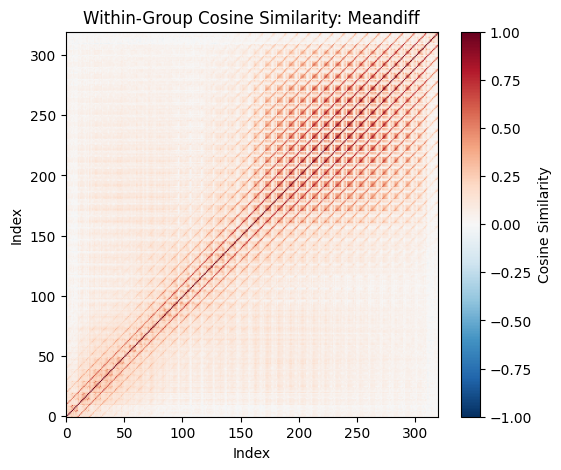

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# === 1. Convert all vectors to NumPy arrays ===
meandiff_np_list = [v.numpy() for vs in layer_diffs.values() for v in vs]
steering_np_list = [v.numpy() for vs in projected_vectors_by_layer.values() for v in vs]
nuisance_np_list = [v.numpy() for vs in pairwise_nuisance.values() for v in vs]

# Stack into matrices
meandiff_mat = np.vstack(meandiff_np_list)   # shape (320, hidden)
steering_mat  = np.vstack(steering_np_list)  # shape (320, hidden)
nuisance_mat  = np.vstack(nuisance_np_list)  # shape (~480, hidden)

# === 1. Norm histograms for each set ===
meandiff_norms = np.linalg.norm(meandiff_mat, axis=1)
steering_norms  = np.linalg.norm(steering_mat, axis=1)
nuisance_norms  = np.linalg.norm(nuisance_mat, axis=1)

plt.figure(figsize=(8, 5))
plt.hist(meandiff_norms, bins=40, alpha=0.6, label="Meandiff")
plt.hist(steering_norms,  bins=40, alpha=0.6, label="Steering")
plt.hist(nuisance_norms,  bins=40, alpha=0.6, label="Nuisance")
plt.title("Norm Distribution: Meandiff vs Steering vs Nuisance")
plt.xlabel("‖v‖₂")
plt.ylabel("Count")
plt.legend()
plt.show()

# === 2. Per-layer mean norms ===
num_layers = len(layer_diffs)  # should be 32
K = len(next(iter(layer_diffs.values())))  # should be 10

# Compute meandiff norms per layer x offset
meandiff_norms_per_layer = np.zeros((num_layers, K))
for i, layer in enumerate(sorted(layer_diffs)):
    for j, v in enumerate(layer_diffs[layer]):
        meandiff_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# Compute steering norms per layer x offset
steering_norms_per_layer = np.zeros((num_layers, K))
for i, layer in enumerate(sorted(projected_vectors_by_layer)):
    for j, v in enumerate(projected_vectors_by_layer[layer]):
        steering_norms_per_layer[i, j] = np.linalg.norm(v.numpy())

# Compute nuisance mean norm per layer (variable count per layer)
nuisance_norms_per_layer = np.array([
    np.mean([np.linalg.norm(v.numpy()) for v in pairwise_nuisance[layer]])
    for layer in sorted(pairwise_nuisance)
])

# Plot per-layer mean norms
layers = np.arange(num_layers)
plt.figure(figsize=(8, 5))
plt.plot(layers, meandiff_norms_per_layer.mean(axis=1), marker='o', label='Meandiff Mean Norm')
plt.plot(layers, steering_norms_per_layer.mean(axis=1), marker='s', label='Steering Mean Norm')
plt.plot(layers, nuisance_norms_per_layer, marker='^', label='Nuisance Mean Norm')
plt.title("Per-Layer Mean Norms for Vector Sets")
plt.xlabel("Layer index (0-based)")
plt.ylabel("Mean ‖v‖₂")
plt.legend()
plt.grid(True)
plt.show()

# === 3. PCA 2D scatter for all vectors ===
all_mat = np.vstack([meandiff_mat, steering_mat, nuisance_mat])
pca = PCA(n_components=2)
coords = pca.fit_transform(all_mat)  # shape (N_total, 2)

# Split back into groups
n1 = meandiff_mat.shape[0]
n2 = steering_mat.shape[0]
n3 = nuisance_mat.shape[0]
coords_meandiff = coords[:n1]
coords_steering  = coords[n1:n1+n2]
coords_nuisance  = coords[-n3:]

plt.figure(figsize=(8, 5))
plt.scatter(coords_meandiff[:, 0], coords_meandiff[:, 1], s=10, label='Meandiff', alpha=0.7)
plt.scatter(coords_steering[:, 0],  coords_steering[:, 1],  s=10, label='Steering', alpha=0.7)
plt.scatter(coords_nuisance[:, 0],  coords_nuisance[:, 1],  s=10, label='Nuisance', alpha=0.7)
plt.title("PCA 2D Scatter: Meandiff vs Steering vs Nuisance")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()

# === 4. Cosine similarity analysis ===
# 4A. Within-group average cosine
cos_md = cosine_similarity(meandiff_mat)
avg_cos_md = np.mean(cos_md[np.triu_indices_from(cos_md, k=1)])

cos_st = cosine_similarity(steering_mat)
avg_cos_st = np.mean(cos_st[np.triu_indices_from(cos_st, k=1)])

cos_nu = cosine_similarity(nuisance_mat)
avg_cos_nu = np.mean(cos_nu[np.triu_indices_from(cos_nu, k=1)])

# 4B. Between-group average cosine
cos_md_st = cosine_similarity(meandiff_mat, steering_mat)
avg_cos_md_st = np.mean(cos_md_st)

cos_md_nu = cosine_similarity(meandiff_mat, nuisance_mat)
avg_cos_md_nu = np.mean(cos_md_nu)

cos_st_nu = cosine_similarity(steering_mat, nuisance_mat)
avg_cos_st_nu = np.mean(cos_st_nu)

print("Average pairwise cosines:")
print(f"  Meandiff vs Meandiff: {avg_cos_md:.3f}")
print(f"  Steering vs Steering: {avg_cos_st:.3f}")
print(f"  Nuisance vs Nuisance: {avg_cos_nu:.3f}")
print()
print("Average cross-group cosines:")
print(f"  Meandiff vs Steering: {avg_cos_md_st:.3f}")
print(f"  Meandiff vs Nuisance: {avg_cos_md_nu:.3f}")
print(f"  Steering vs Nuisance: {avg_cos_st_nu:.3f}")

# === 5. Heatmap of within-group cosine distributions (Meandiff only) ===
plt.figure(figsize=(6, 5))
plt.imshow(cos_md, aspect='auto', origin='lower', cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label="Cosine Similarity")
plt.title("Within-Group Cosine Similarity: Meandiff")
plt.xlabel("Index")
plt.ylabel("Index")
plt.show()
